In [63]:
from keras.preprocessing import image
import numpy as np
import os
from keras.applications import mobilenet
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import matplotlib.image as mpimg

In [60]:
def list_files(dir_root, format_image):
    files_result = []
    class_labels = []
    ind = 0
    for dirs in sorted(os.listdir(dir_root)):
        if dirs.endswith('.DS_Store'): continue
        path_dir = os.path.join(dir_root,dirs)
        if (os.path.isdir(path_dir)):
            files = os.listdir(path_dir)
            file_d = [os.path.join(path_dir,f) for f in files if f.endswith(format_image)]
            del files
            for f in file_d:
                files_result.append(f)
                class_labels.append(ind)
            del file_d
            ind += 1
    return files_result, class_labels

def read_img(filepath, size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img

def extract_features(list_files, INPUT_SIZE = 224, dir_='./data',filename=None):
    x_features = np.zeros((len(list_files), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
    model_bottleneck = mobilenet.MobileNet(input_shape=(INPUT_SIZE,INPUT_SIZE,3),weights='imagenet', include_top=False, pooling='avg')
    
    for i, f in enumerate(list_files):
        img = read_img(f, (INPUT_SIZE, INPUT_SIZE))
        x = mobilenet.preprocess_input(np.expand_dims(img.copy(), axis=0))
        x_features[i] = x
    print('shape: {} size: {:,}'.format(x_features.shape, x_features.size))
    
    x_app_feature = model_bottleneck.predict(x_features, batch_size=32, verbose=1)
    del x_features
    
    file_name = os.path.join(dir_,filename)
    np.save(file_name, x_app_feature)
    
    del x_app_feature
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    #function to print this confusion matrix is copied from:
    #http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py 
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def classification(file_train, file_val, train_labels, validation_labels, class_names):
    SEED=123
    train_x_bf =np.load(file_train)
    valid_x_bf =np.load(file_val)
    print('train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
    print('valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))
    
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
    logreg.fit(train_x_bf, train_labels)
    valid_preds = logreg.predict(valid_x_bf)
    print('accuracy:', accuracy_score(validation_labels, valid_preds))
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(validation_labels, valid_preds)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()



## Load and prepare image data

The training image is downloaded from Kaggle dataset. More detail information, please read README.md file in the data folder.

The dataset is in format '.png' and it is organized in 12 folders, one folder for each class.

In this modelling, the list of file name in each class is retrieves and labelled based on order of folder name. Subsequently, the file names is shuffled and split into training and testing dataset.

In [28]:
#read list train files
list_files_, class_labels = list_files('./data/train','png')
X_train_files, X_test_files, y_train, y_test = train_test_split(list_files_, class_labels, test_size=0.1, random_state=123)


Each set of training set and testing set are extracted using deep learning mobilenet architecture with pre-trained weight of imagenet (from github of François Chollet). Because the feature extraction process is time consuming, the extracted features are saved and can be used when other classifier setting will be evaluated in the future.

In [51]:
#extract feature training and testing, save in the data folder
training_file_name = 'train_seedling_mobilenet.npy'
testing_file_name = 'test_seedling_mobilenet.npy'

#extract features file testing
extract_features(list_files=X_test_files, filename=testing_file_name)

#extract features file training
extract_features(list_files=X_train_files, filename=training_file_name)



shape: (475, 224, 224, 3) size: 71,500,800
475/475 [==============================] - 96s 203ms/step
shape: (4275, 224, 224, 3) size: 643,507,200
4275/4275 [==============================] - 794s 186ms/step


The labels of training set and testing set are also saved.

In [70]:
np.save('./data/train_labels.npy', y_train)
np.save('./data/test_labels.npy', y_test)

## Image Classification

train bottleneck features shape: (4275, 1024) size: 4,377,600
valid bottleneck features shape: (475, 1024) size: 486,400
accuracy: 0.88


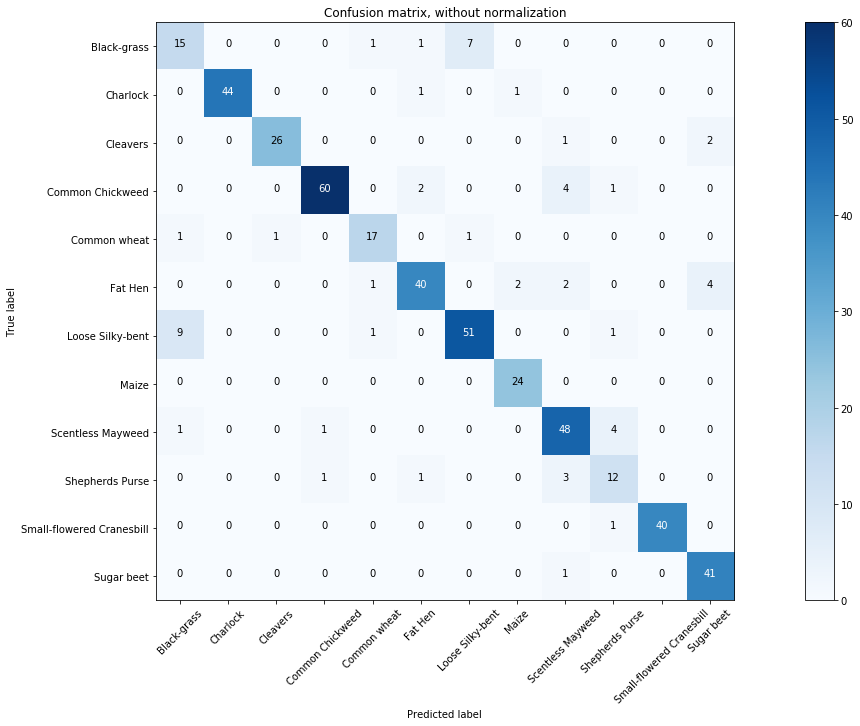

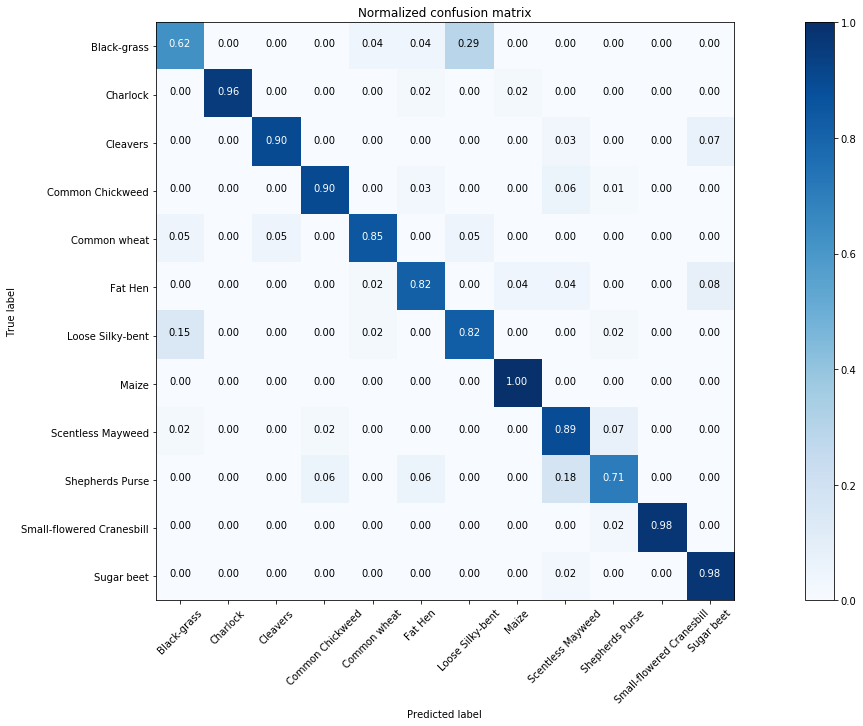

In [61]:
file_train = './data/train_seedling_mobilenet.npy'
file_val = './data/test_seedling_mobilenet.npy'

class_labels = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
classification(file_train, file_val, y_train, y_test, class_labels)

#### Notes:

The overall accuracy is around 88%

From the confusion matrix, the two lowest accuracy is 'Black Grass' and 'Shepperd Purse' with accuracy 62% and 71% respectively.

About 30% of 'Black Grass' are predicted as 'Loose Silky-bent' and about 15% of 'Loose Silky-bent' are predicted as 'Black Grass'. Visually, those two classes are very similar.

Future improvement planning is by using image enhancement method or performing parameter tuning for the classifiers.

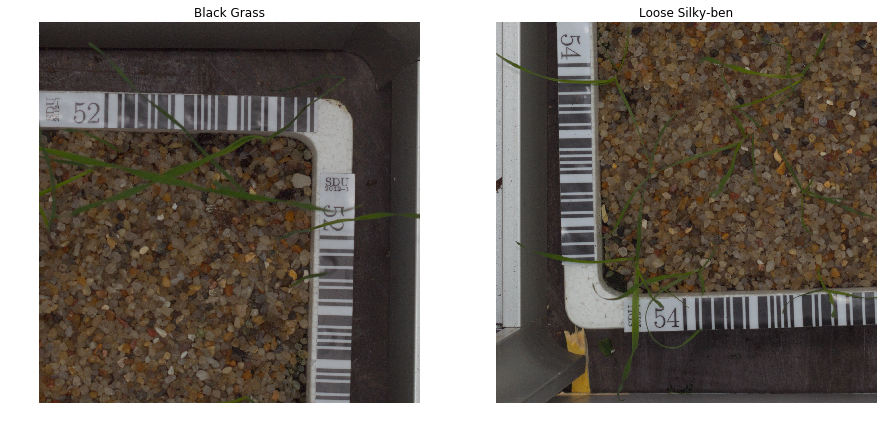

In [69]:
fig = plt.figure(figsize=(15,15))
a=fig.add_subplot(1,2,1)
img = mpimg.imread('./data/black_grass_0c67c3fc3.png')
imgplot = plt.imshow(img)
a.set_title('Black Grass')
a.axis('off')

a=fig.add_subplot(1,2,2)
img = mpimg.imread('./data/loose Silky-bent_0d96cc35d.png')
imgplot = plt.imshow(img)
a.set_title('Loose Silky-ben')
a.axis('off')
plt.show()